In [53]:
# importing baseline packages
import os

# importing data processing packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from feature_engine import imputation as feimp
from feature_engine import encoding as feenc
from feature_engine import discretisation as fedisc

# importing machine learning packages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# importing visualisation libraries
import matplotlib.pyplot as plt
plt.style.use('../conf/custom_mpl_stylesheet.mplstyle')

# import custom classes
from custom_utils import DataPrepUtil

In [ ]:
drop_cols = ['Id', 'SalePrice']
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
X_train, X_val, y_train, y_val = train_test_split(train.drop(['Id', 'SalePrice'], axis=1), train['SalePrice'], test_size=0.2, random_state=43)

In [ ]:
datautil = DataPrepUtil()

In [ ]:
missing_val_cols = [var for var in train.columns if train[var].isna().sum() > 0]
train[missing_val_cols]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=100)
axes[0].bar(train.groupby('MoSold')['SalePrice'].mean().index, train.groupby('MoSold')['SalePrice'].mean(), color='turquoise', width=0.7, alpha=0.75)
axes[0].set_xlabel('MoSold')
axes[0].set_ylabel('SalePrice')
axes[0].set_title('Mean sale price per month sold')
axes[1].bar(train.groupby('MoSold')['SalePrice'].median().index, train.groupby('MoSold')['SalePrice'].median(),  color='turquoise', width=0.7, alpha=0.75)
axes[1].set_xlabel('MoSold')
axes[1].set_ylabel('SalePrice')
axes[1].set_title('Median sale price per month sold')

plt.tight_layout()
plt.show()

In [ ]:
datautil.plot_filled_values_percent(train[missing_val_cols], dpi=100)

In [ ]:
# list of categorical variables
cat_cols = [var for var in train.columns if train[var].dtype == 'O']

# list of the non-categorical variables
non_cat_cols = [var for var in train.columns if train[var].dtype !='O']

# list of variables that contain date & time information
dt_cols = [var for var in train.columns if 'Yr' in var or 'Year' in var]

# discrete numerical variables (i.e., numerical variables with a finite small set of distinct values (<20)
disc_cols = [var for var in non_cat_cols if train[var].nunique() < 25 and var not in dt_cols]

# list of numerical variables
num_cols = [var for var in non_cat_cols if var not in disc_cols and var not in drop_cols]

In [ ]:
disc_cols.sort()

In [ ]:
cardinality = train[cat_cols].nunique()
train[cardinality.index[0]].count()

In [ ]:
datautil.plot_cat_col_cardinality(train[cat_cols], dpi=100)

## Data Imputation

In [ ]:
X_train[disc_cols] = X_train[disc_cols].astype('O')
X_val[disc_cols] = X_val[disc_cols].astype('O')

In [32]:
house_pipe = Pipeline([
    ('imputer_num', feimp.MeanMedianImputer(imputation_method='median',
                                          variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    
    ('imputer_cat', feimp.CategoricalImputer(variables=cat_cols)),

    # categorical encoding - section 7-10
    ('rare_label_enc', feenc.RareLabelEncoder(
        tol=0.05, n_categories=1, variables=cat_cols+disc_cols)),
    
    ('categorical_enc', feenc.OrdinalEncoder(
        encoding_method='ordered', variables=cat_cols+disc_cols)),

    # discretisation + encoding - section 12
    ('discretisation', fedisc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=num_cols)),
    
    ('encoding', feenc.OrdinalEncoder(
        encoding_method='ordered', variables=num_cols)),

    # feature Scaling - section 18
    ('scaler', StandardScaler()),
    
    # regression
    ('lasso', Lasso(random_state=0))
])

In [36]:
house_pipe.fit(X_train, y_train)

X_train_pred = house_pipe.predict(X_train)
X_val_pred = house_pipe.predict(X_val)

In [37]:
# check model performance:
print('train mse: {}'.format(mean_squared_error(y_train, X_train_pred)))
print('train rmse: {}'.format(mean_squared_error(y_train, X_train_pred, squared=False)))
print('train r2: {}'.format(r2_score(y_train, X_train_pred)))
print()
print('test mse: {}'.format(mean_squared_error(y_val, X_val_pred)))
print('test rmse: {}'.format(mean_squared_error(y_val, X_val_pred, squared=False)))
print('test r2: {}'.format(r2_score(y_val, X_val_pred)))

train mse: 1123921813.362857
train rmse: 33524.94315226884
train r2: 0.8213238975131402

test mse: 1119231552.1284595
test rmse: 33454.91820537691
test r2: 0.824187139950355


Text(0, 0.5, 'Predicted Price')

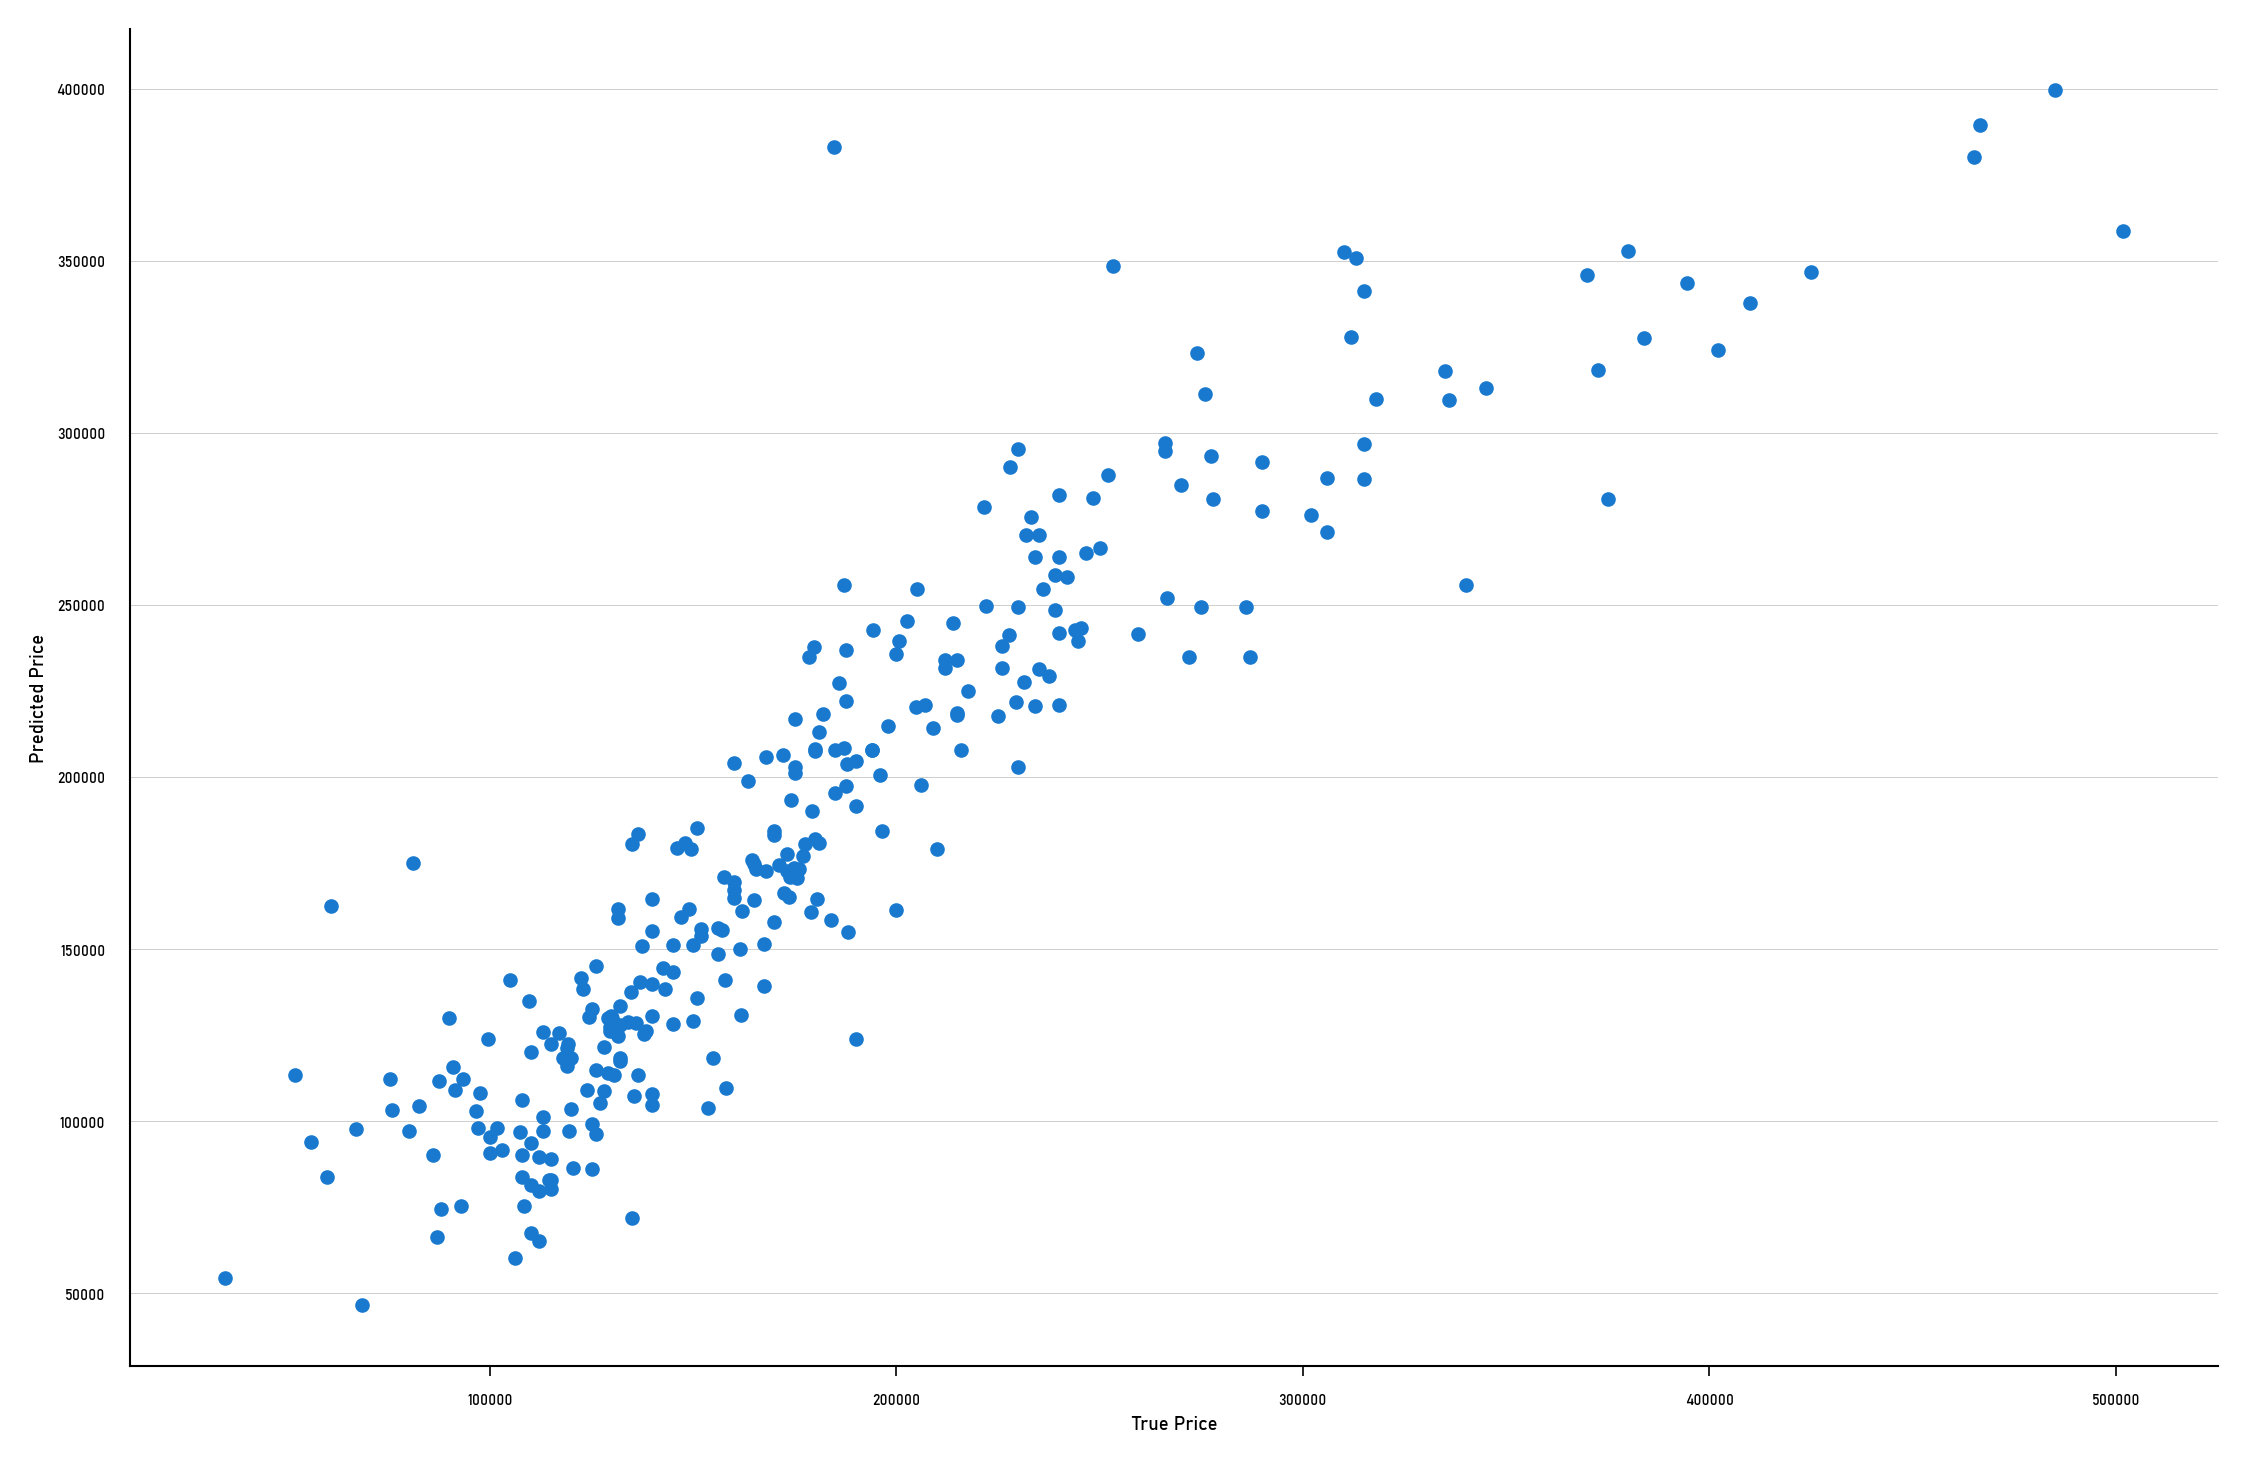

In [38]:
# plot predictions vs real value

plt.scatter(y_val,X_val_pred)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

KeyboardInterrupt: 

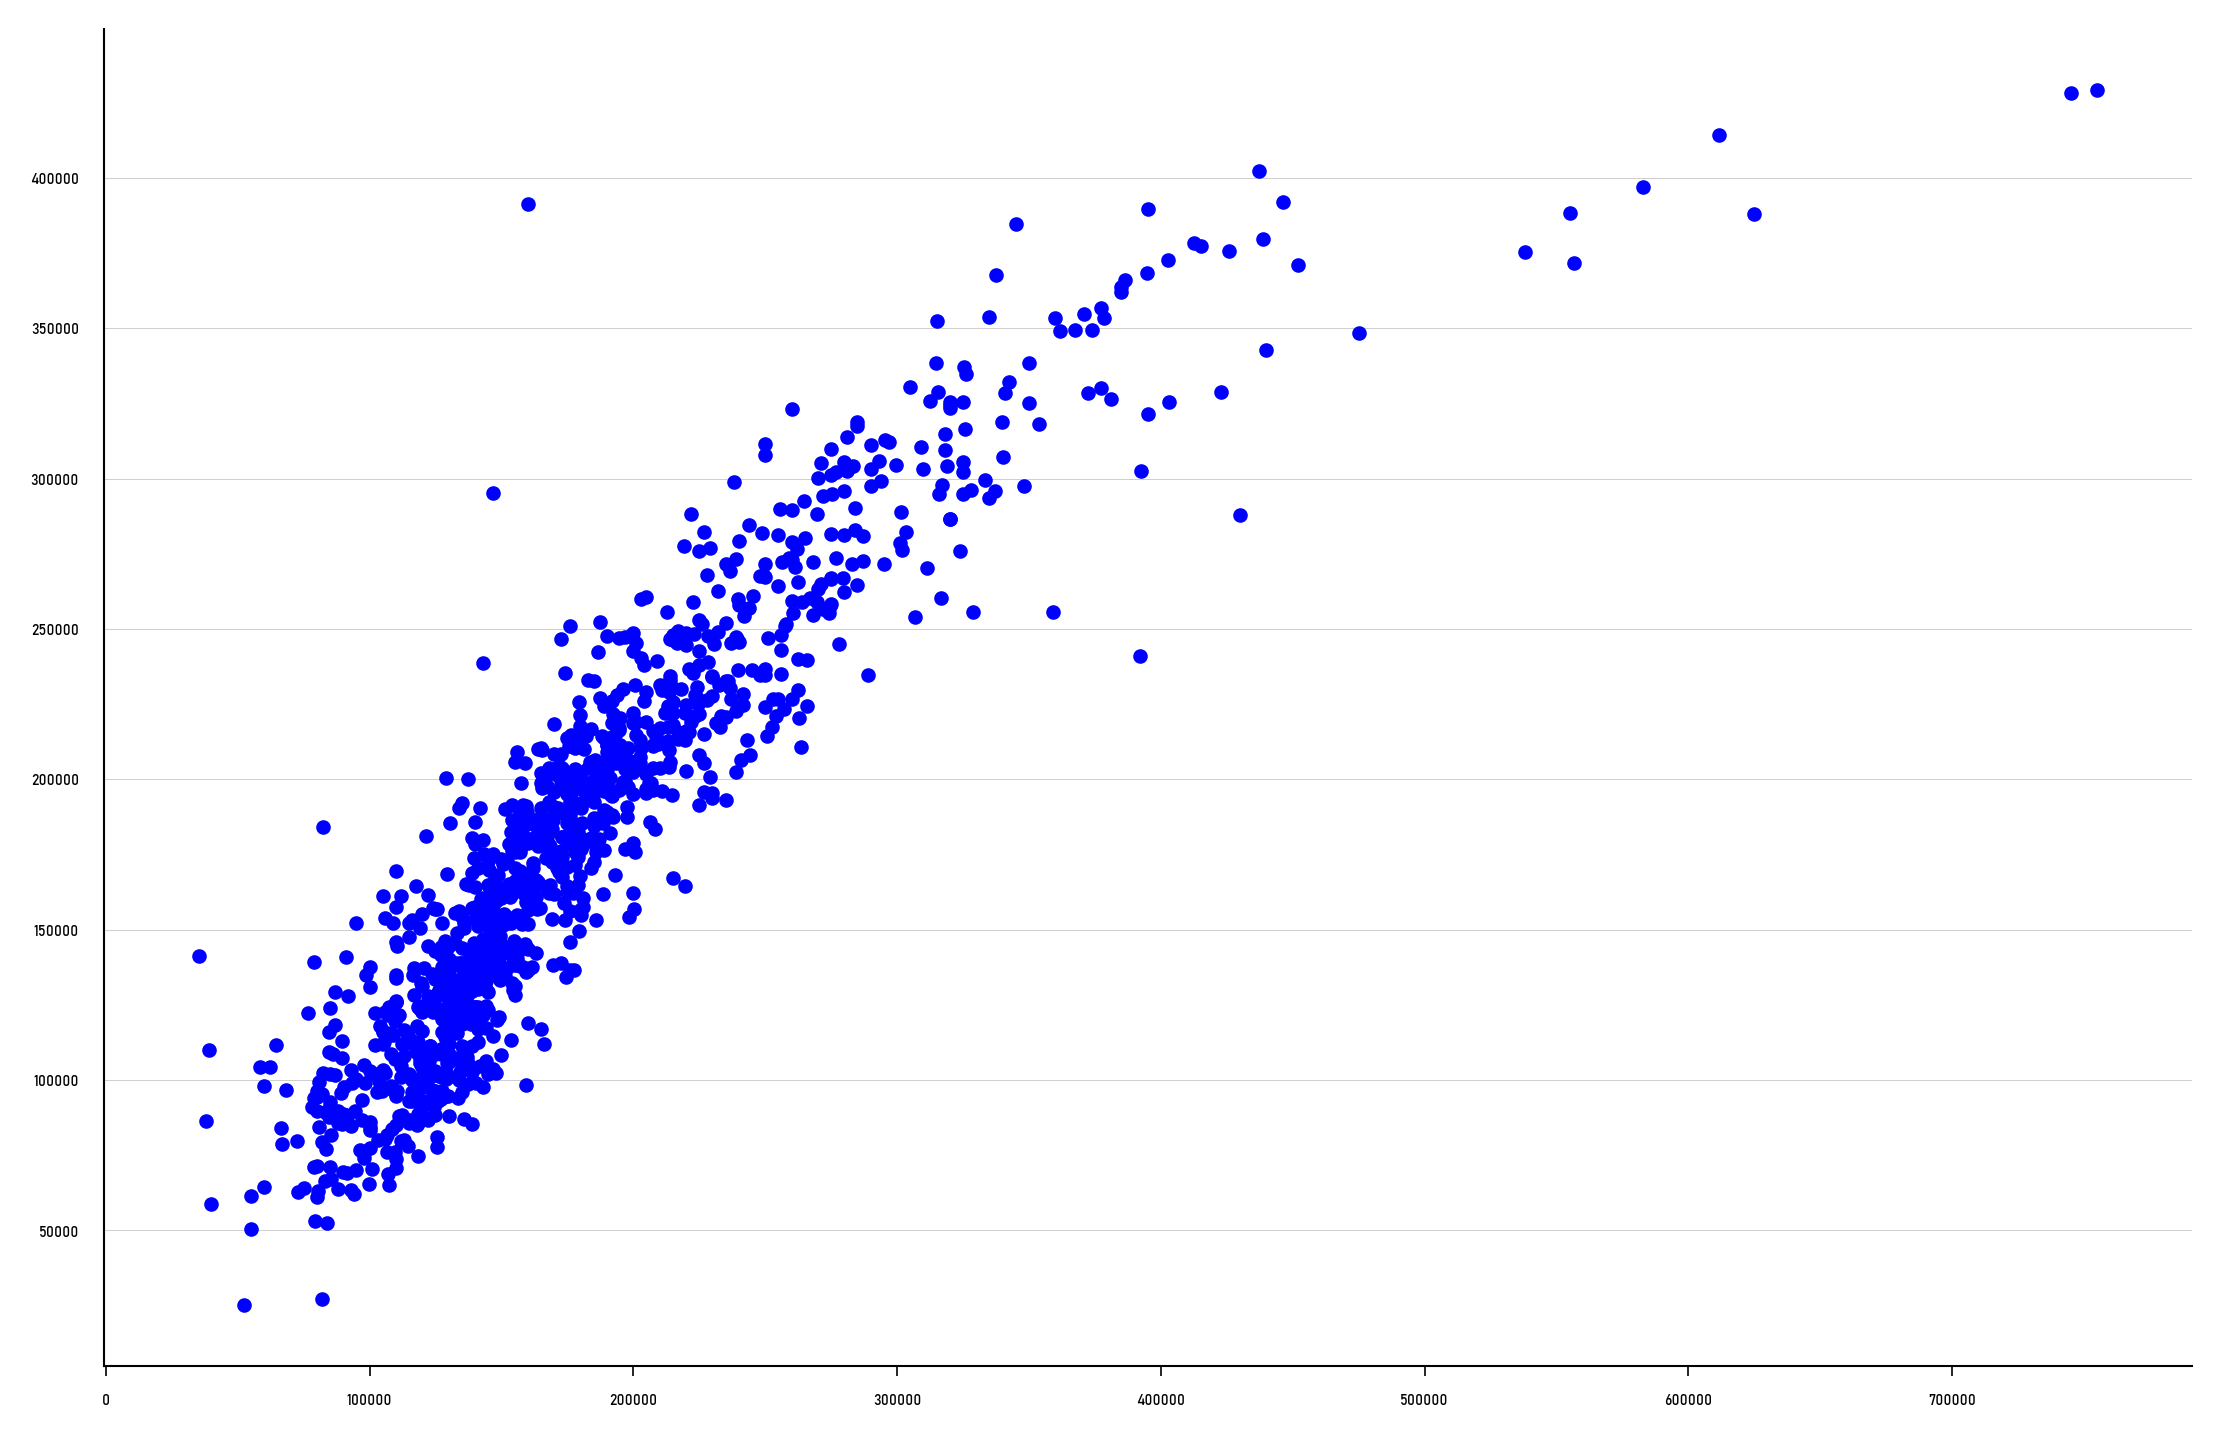

In [51]:
trans_pipe = Pipeline([
    ('imputer_num', feimp.MeanMedianImputer(imputation_method='median',
                                          variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    
    ('imputer_cat', feimp.CategoricalImputer(variables=cat_cols)),

    # categorical encoding - section 7-10
    ('rare_label_enc', feenc.RareLabelEncoder(
        tol=0.05, n_categories=1, variables=cat_cols+disc_cols)),
    
    ('categorical_enc', feenc.OrdinalEncoder(
        encoding_method='ordered', variables=cat_cols+disc_cols)),

    # discretisation + encoding - section 12
    ('discretisation', fedisc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=num_cols)),
    
    ('encoding', feenc.OrdinalEncoder(
        encoding_method='ordered', variables=num_cols)),

    # feature Scaling - section 18
    ('scaler', StandardScaler())
])



X_train_trans = trans_pipe.fit_transform(X_train, y_train)
md_lasso = Lasso(alpha=0.1, random_state=43)
md_lasso.fit(X_train_trans, y_train)

y_pred = md_lasso.predict(X_train_trans)

# Scatter plot of Actual vs. Predicted
plt.scatter(y_train, y_pred, color='blue', label='data')  # Actual vs. Predicted scatter plot

# Generate a sequence of x values spanning the range of the current x axis
x_plot = np.linspace(min(y_train), max(y_train), len(y_train))

# Create lasso regression line
y_plot = md_lasso.predict(x_plot[:, None])

# Overlay regression line
plt.plot(x_plot, y_plot, color='red', label='Lasso Regression')

plt.xlabel('Actual Observations')
plt.ylabel('Predictions')
plt.title('Lasso Regression Line Overlaid on Scatter Plot')
plt.legend()
plt.show()

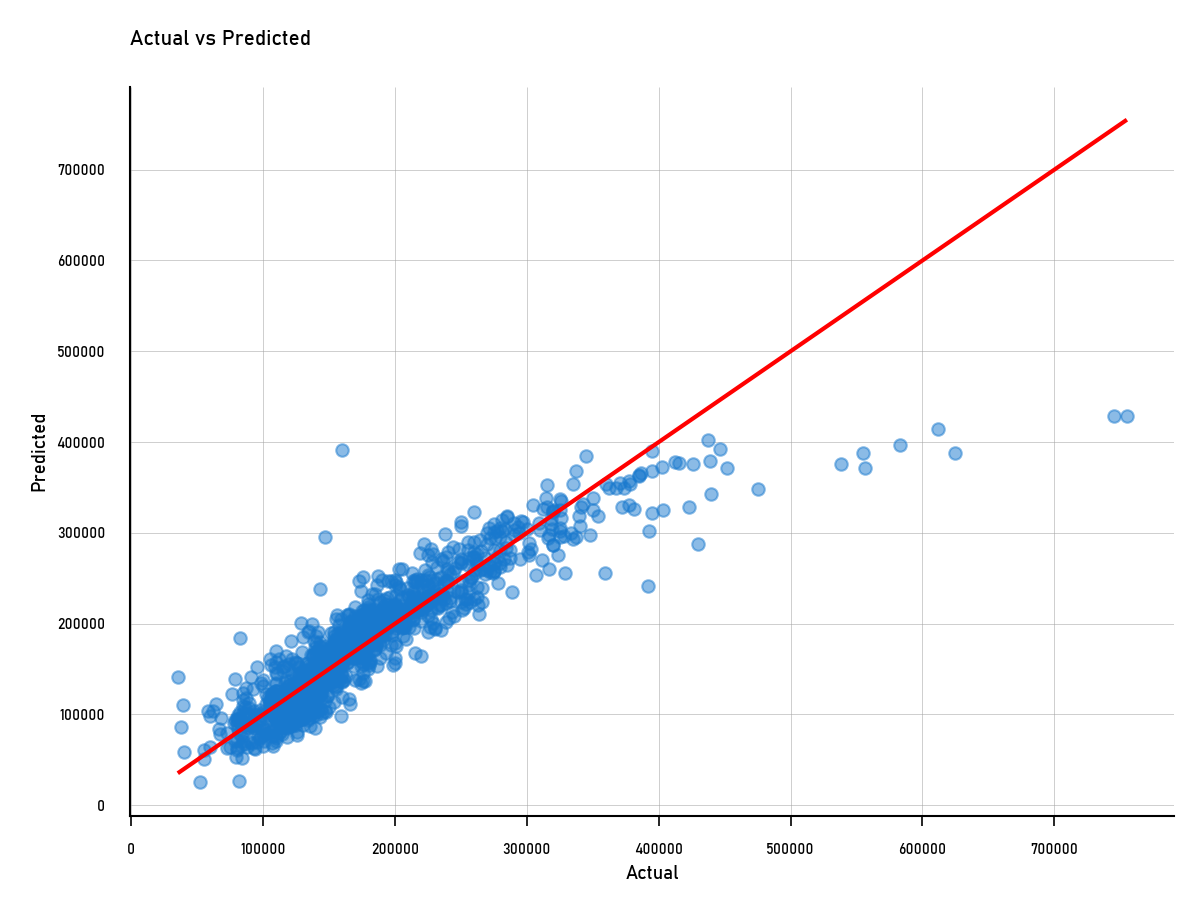

In [52]:
trans_pipe = Pipeline([
    ('imputer_num', feimp.MeanMedianImputer(imputation_method='median',
                                          variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    
    ('imputer_cat', feimp.CategoricalImputer(variables=cat_cols)),

    # categorical encoding - section 7-10
    ('rare_label_enc', feenc.RareLabelEncoder(
        tol=0.05, n_categories=1, variables=cat_cols+disc_cols)),
    
    ('categorical_enc', feenc.OrdinalEncoder(
        encoding_method='ordered', variables=cat_cols+disc_cols)),

    # discretisation + encoding - section 12
    ('discretisation', fedisc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=num_cols)),
    
    ('encoding', feenc.OrdinalEncoder(
        encoding_method='ordered', variables=num_cols)),

    # feature Scaling - section 18
    ('scaler', StandardScaler())
])



X_train_trans = trans_pipe.fit_transform(X_train, y_train)
md_lasso = Lasso(alpha=0.1, random_state=43)
md_lasso.fit(X_train_trans, y_train)

y_pred = md_lasso.predict(X_train_trans)


plt.figure(figsize=(8,6))
plt.scatter(y_train, y_pred, alpha=0.5)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red') # A red line that represents perfect fit

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

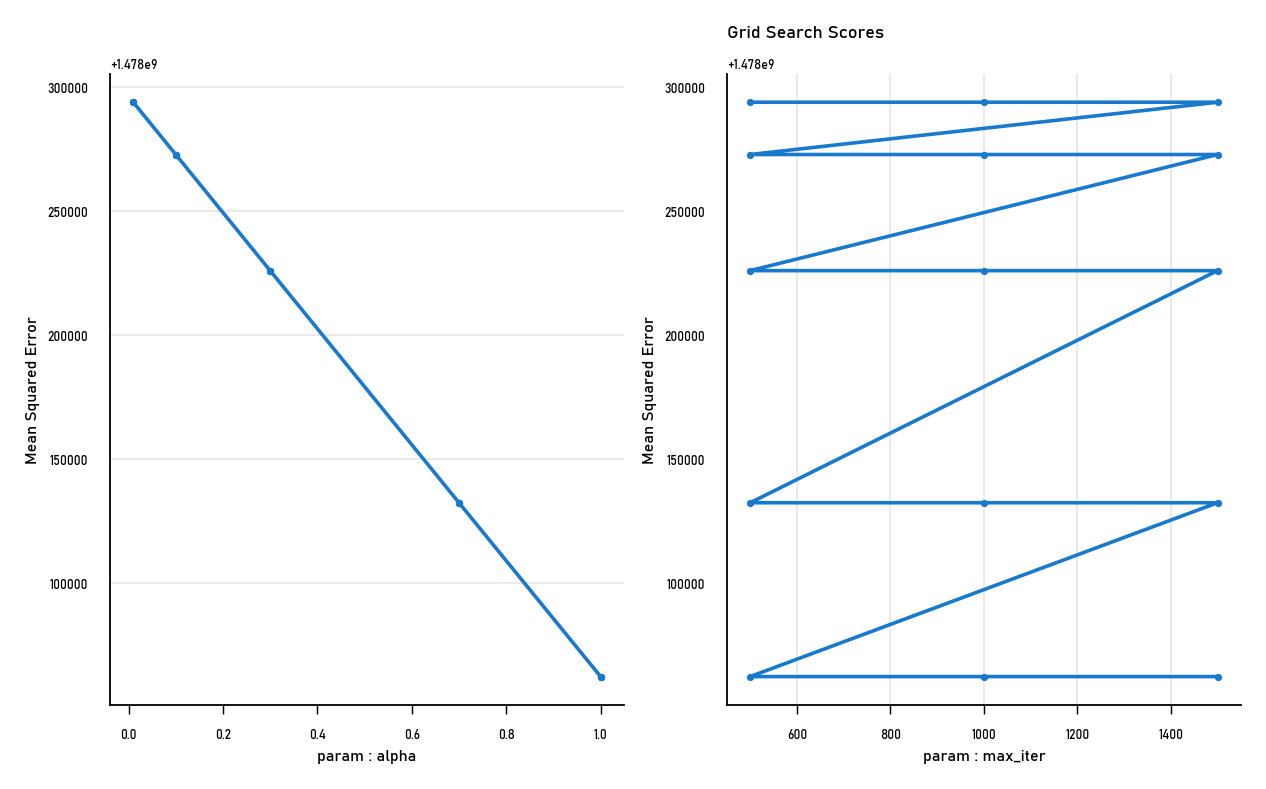

In [63]:
trans_pipe = Pipeline([
    ('imputer_num', feimp.MeanMedianImputer(imputation_method='median',
                                          variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    
    ('imputer_cat', feimp.CategoricalImputer(variables=cat_cols)),

    # categorical encoding - section 7-10
    ('rare_label_enc', feenc.RareLabelEncoder(
        tol=0.05, n_categories=1, variables=cat_cols+disc_cols)),
    
    ('categorical_enc', feenc.OrdinalEncoder(
        encoding_method='ordered', variables=cat_cols+disc_cols)),

    # discretisation + encoding - section 12
    ('discretisation', fedisc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=num_cols)),
    
    ('encoding', feenc.OrdinalEncoder(
        encoding_method='ordered', variables=num_cols)),

    # feature Scaling - section 18
    ('scaler', StandardScaler())
])

# Defining the hyperparameters grid to search through
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.7, 1.0],
              'max_iter': [500, 1000, 1500]}

X_train_trans = trans_pipe.fit_transform(X_train, y_train)
md_lasso = Lasso(random_state=43)
# Instantiate GridSearchCV with Lasso estimator and param grid
grid_search = GridSearchCV(estimator=md_lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_trans, y_train)

# Suppose "grid_search" is the fitted GridSearchCV object
# We convert the results into a DataFrame for easier handling
results = pd.DataFrame(grid_search.cv_results_)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 6), dpi=130)

# Plot mean test score (e.g., mean squared error) for each alpha
axes[0].plot(results['param_alpha'], -results['mean_test_score'], marker = '.')
axes[0].set_xlabel("param : alpha")
axes[0].set_ylabel("Mean Squared Error")

axes[1].plot(results['param_max_iter'], -results['mean_test_score'], marker = '.')
axes[1].set_xlabel("param : max_iter")
axes[1].set_ylabel("Mean Squared Error")

plt.title("Grid Search Scores")
plt.grid()
plt.show()

In [64]:
# and finally let's check the performance over the test set
print(("best regression from grid search: %.3f"
       % grid_search.score(X_train_trans, y_train)))

best regression from grid search: -1123921813.363


In [65]:
grid_search.best_estimator_

Lasso(max_iter=500, random_state=43)